# 实验三：基于 DeepLabv3 的语义分割 (PyTorch基础版)

本 Notebook 实现了使用 PyTorch 和预训练的 DeepLabv3 模型对 PASCAL VOC2012 数据集进行语义分割。

**实验流程:**
1.  **环境设置**: 导入所需库并设置计算设备。
2.  **数据准备**: 创建一个自定义的 `Dataset` 类来加载和预处理 VOC2012 数据。
3.  **模型构建**: 加载 `torchvision` 中预训练的 DeepLabv3 模型，并根据我们的任务修改其分类头。
4.  **模型微调**: 在 VOC2012 训练集上对模型的分类头进行微调。
5.  **结果验证与可视化**: 加载训练好的模型，在验证集上进行预测，并将分割结果可视化。

**文件结构要求:**
- 数据集应解压在 `./data/VOC2012/` 目录下。
- 最终训练好的模型将保存为 `./deeplabv3_voc.pth`。

In [1]:
# ==============================================================================
# 1. 导入所需的库
# 包含了 PyTorch、torchvision、图像处理和可视化的常用库
# ==============================================================================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.functional as F
import random
import warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

warnings.filterwarnings("ignore")
# 检查并打印 PyTorch 版本
print(f"PyTorch Version: {torch.__version__}")

# 设置计算设备 (优先使用 GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.5.1+cu121
Using device: cuda


In [2]:
# ==============================================================================
# 2. 定义超参数和文件路径
# ==============================================================================
# 数据集有20个类别 + 1个背景类别
NUM_CLASSES = 21 
# 数据集根目录
DATA_DIR = 'data/VOC2012'
# 预训练模型保存路径
MODEL_SAVE_PATH = 'models/deeplabv3_voc.pth'
# 为新模型定义一个不同的保存路径
IMPROVED_MODEL_SAVE_PATH = 'models/deeplabv3_voc_improved.pth'

# 训练参数
# --- MODIFIED ---
# BATCH_SIZE 减小以降低显存使用。如果仍然内存不足，可以尝试 2。
BATCH_SIZE = 4 
EPOCHS = 100     # 训练轮次
LEARNING_RATE = 0.01

In [3]:
# ==============================================================================
# 3. 创建自定义数据集类
# 这个类用于加载 PASCAL VOC2012 数据集。
# 它会读取图片和对应的分割掩码，并进行必要的预处理和数据增强。
# ==============================================================================
class VOCDataset(Dataset):
    """
    PASCAL VOC2012 语义分割数据集的自定义数据集类。
    """
    def __init__(self, root, split='train', crop_size=(513, 513), ignore_label=255):
        self.root = root
        self.split = split
        self.crop_size = crop_size
        self.ignore_label = ignore_label
        
        self.images_dir = os.path.join(root, 'JPEGImages')
        self.masks_dir = os.path.join(root, 'SegmentationClass')
        
        list_file = os.path.join(root, f'ImageSets/Segmentation/{split}.txt')
        with open(list_file, 'r') as f:
            self.filenames = [line.strip() for line in f.readlines()]

        # PDF中使用的图像均值和标准差 (从BGR转换为RGB顺序)
        self.mean = [123.675, 116.28, 103.53]
        self.std = [58.395, 57.120, 57.375]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        
        img_path = os.path.join(self.images_dir, f'{filename}.jpg')
        mask_path = os.path.join(self.masks_dir, f'{filename}.png')
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)
        
        # --- 数据增强和预处理 ---
        # 1. 随机缩放 (0.5 - 2.0)
        scale_factor = random.uniform(0.5, 2.0)
        new_size = (int(image.size[0] * scale_factor), int(image.size[1] * scale_factor))
        image = image.resize(new_size, Image.BILINEAR)
        mask = mask.resize(new_size, Image.NEAREST)

        # 2. 随机裁剪到 crop_size
        if image.size[0] < self.crop_size[0] or image.size[1] < self.crop_size[1]:
            pad_w = max(0, self.crop_size[0] - image.size[0])
            pad_h = max(0, self.crop_size[1] - image.size[1])
            image = F.pad(image, (0, 0, pad_w, pad_h), fill=0)
            mask = F.pad(mask, (0, 0, pad_w, pad_h), fill=self.ignore_label)

        x = random.randint(0, image.size[0] - self.crop_size[0])
        y = random.randint(0, image.size[1] - self.crop_size[1])
        image = image.crop((x, y, x + self.crop_size[0], y + self.crop_size[1]))
        mask = mask.crop((x, y, x + self.crop_size[0], y + self.crop_size[1]))

        # 3. 随机水平翻转
        if random.random() > 0.5:
            image = F.hflip(image)
            mask = F.hflip(mask)
        
        # 4. 转换为 Tensor 并进行归一化
        image = F.to_tensor(image) * 255.0
        image = F.normalize(image, mean=self.mean, std=self.std)
        
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

In [4]:
# ==============================================================================
# 4. 定义模型、损失函数和优化器
# ==============================================================================
def create_model(num_classes):
    """
    创建 DeepLabv3 模型。
    - 使用在 COCO 上预训练的 ResNet-101 作为骨干网络。
    - 替换分类头以匹配我们的类别数。
    - 冻结骨干网络，只微调分类头。
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
    model.classifier = DeepLabHead(2048, num_classes)
    
    # 冻结骨干网络参数
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

# 实例化模型、损失函数、优化器和学习率调度器
model = create_model(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0)

# 创建 DataLoader
train_dataset = VOCDataset(root=DATA_DIR, split='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
# ==============================================================================
# 5. 训练模型
# ==============================================================================
print("开始微调训练...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

# 保存模型权重
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"训练完成，模型已保存至 {MODEL_SAVE_PATH}")

开始微调训练...


Epoch 1/100: 100%|██████████| 366/366 [00:57<00:00,  6.40it/s, loss=0.1846]


Epoch [1/100], Loss: 0.6678, LR: 0.009998


Epoch 2/100: 100%|██████████| 366/366 [00:57<00:00,  6.37it/s, loss=0.5591]


Epoch [2/100], Loss: 0.3971, LR: 0.009990


Epoch 3/100: 100%|██████████| 366/366 [00:57<00:00,  6.33it/s, loss=0.3731]


Epoch [3/100], Loss: 0.3260, LR: 0.009978


Epoch 4/100: 100%|██████████| 366/366 [00:57<00:00,  6.32it/s, loss=0.3958]


Epoch [4/100], Loss: 0.3136, LR: 0.009961


Epoch 5/100: 100%|██████████| 366/366 [00:57<00:00,  6.32it/s, loss=0.2153]


Epoch [5/100], Loss: 0.2967, LR: 0.009938


Epoch 6/100: 100%|██████████| 366/366 [01:14<00:00,  4.92it/s, loss=0.2549]


Epoch [6/100], Loss: 0.2714, LR: 0.009911


Epoch 7/100: 100%|██████████| 366/366 [01:28<00:00,  4.16it/s, loss=0.3400]


Epoch [7/100], Loss: 0.2523, LR: 0.009880


Epoch 8/100: 100%|██████████| 366/366 [01:01<00:00,  5.95it/s, loss=0.3580]


Epoch [8/100], Loss: 0.2675, LR: 0.009843


Epoch 9/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.2294]


Epoch [9/100], Loss: 0.2537, LR: 0.009801


Epoch 10/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.2391]


Epoch [10/100], Loss: 0.2569, LR: 0.009755


Epoch 11/100: 100%|██████████| 366/366 [00:58<00:00,  6.27it/s, loss=0.0816]


Epoch [11/100], Loss: 0.2418, LR: 0.009704


Epoch 12/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0561]


Epoch [12/100], Loss: 0.2340, LR: 0.009649


Epoch 13/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0933]


Epoch [13/100], Loss: 0.2408, LR: 0.009589


Epoch 14/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0805]


Epoch [14/100], Loss: 0.2222, LR: 0.009524


Epoch 15/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.1509]


Epoch [15/100], Loss: 0.2113, LR: 0.009455


Epoch 16/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.1133]


Epoch [16/100], Loss: 0.1922, LR: 0.009382


Epoch 17/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1490]


Epoch [17/100], Loss: 0.2068, LR: 0.009304


Epoch 18/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.3361]


Epoch [18/100], Loss: 0.1963, LR: 0.009222


Epoch 19/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0499]


Epoch [19/100], Loss: 0.2030, LR: 0.009135


Epoch 20/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1438]


Epoch [20/100], Loss: 0.1918, LR: 0.009045


Epoch 21/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0592]


Epoch [21/100], Loss: 0.1751, LR: 0.008951


Epoch 22/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0737]


Epoch [22/100], Loss: 0.1817, LR: 0.008853


Epoch 23/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.2294]


Epoch [23/100], Loss: 0.1848, LR: 0.008751


Epoch 24/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.1071]


Epoch [24/100], Loss: 0.1757, LR: 0.008645


Epoch 25/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0593]


Epoch [25/100], Loss: 0.1511, LR: 0.008536


Epoch 26/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0807]


Epoch [26/100], Loss: 0.1670, LR: 0.008423


Epoch 27/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.1053]


Epoch [27/100], Loss: 0.1714, LR: 0.008307


Epoch 28/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0967]


Epoch [28/100], Loss: 0.1805, LR: 0.008187


Epoch 29/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.1577]


Epoch [29/100], Loss: 0.1679, LR: 0.008065


Epoch 30/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.2782]


Epoch [30/100], Loss: 0.1663, LR: 0.007939


Epoch 31/100: 100%|██████████| 366/366 [00:58<00:00,  6.31it/s, loss=0.3058]


Epoch [31/100], Loss: 0.1462, LR: 0.007810


Epoch 32/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0446]


Epoch [32/100], Loss: 0.1441, LR: 0.007679


Epoch 33/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0584]


Epoch [33/100], Loss: 0.1376, LR: 0.007545


Epoch 34/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0754]


Epoch [34/100], Loss: 0.1360, LR: 0.007409


Epoch 35/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.2122]


Epoch [35/100], Loss: 0.1441, LR: 0.007270


Epoch 36/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1706]


Epoch [36/100], Loss: 0.1523, LR: 0.007129


Epoch 37/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0775]


Epoch [37/100], Loss: 0.1424, LR: 0.006986


Epoch 38/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.5394]


Epoch [38/100], Loss: 0.1466, LR: 0.006841


Epoch 39/100: 100%|██████████| 366/366 [00:58<00:00,  6.31it/s, loss=0.0596]


Epoch [39/100], Loss: 0.1443, LR: 0.006694


Epoch 40/100: 100%|██████████| 366/366 [00:58<00:00,  6.31it/s, loss=0.0479]


Epoch [40/100], Loss: 0.1383, LR: 0.006545


Epoch 41/100: 100%|██████████| 366/366 [00:58<00:00,  6.30it/s, loss=0.0878]


Epoch [41/100], Loss: 0.1329, LR: 0.006395


Epoch 42/100: 100%|██████████| 366/366 [00:58<00:00,  6.31it/s, loss=0.1545]


Epoch [42/100], Loss: 0.1309, LR: 0.006243


Epoch 43/100: 100%|██████████| 366/366 [00:58<00:00,  6.31it/s, loss=0.2149]


Epoch [43/100], Loss: 0.1266, LR: 0.006091


Epoch 44/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1121]


Epoch [44/100], Loss: 0.1251, LR: 0.005937


Epoch 45/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1201]


Epoch [45/100], Loss: 0.1262, LR: 0.005782


Epoch 46/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0879]


Epoch [46/100], Loss: 0.1239, LR: 0.005627


Epoch 47/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.1576]


Epoch [47/100], Loss: 0.1219, LR: 0.005471


Epoch 48/100: 100%|██████████| 366/366 [00:58<00:00,  6.27it/s, loss=0.0674]


Epoch [48/100], Loss: 0.1307, LR: 0.005314


Epoch 49/100: 100%|██████████| 366/366 [00:58<00:00,  6.27it/s, loss=0.2258]


Epoch [49/100], Loss: 0.1197, LR: 0.005157


Epoch 50/100: 100%|██████████| 366/366 [00:58<00:00,  6.26it/s, loss=0.0424]


Epoch [50/100], Loss: 0.1206, LR: 0.005000


Epoch 51/100: 100%|██████████| 366/366 [00:58<00:00,  6.27it/s, loss=0.0480]


Epoch [51/100], Loss: 0.1189, LR: 0.004843


Epoch 52/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.1064]


Epoch [52/100], Loss: 0.1215, LR: 0.004686


Epoch 53/100: 100%|██████████| 366/366 [00:58<00:00,  6.27it/s, loss=0.2630]


Epoch [53/100], Loss: 0.1168, LR: 0.004529


Epoch 54/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0583]


Epoch [54/100], Loss: 0.1089, LR: 0.004373


Epoch 55/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.1244]


Epoch [55/100], Loss: 0.1116, LR: 0.004218


Epoch 56/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0530]


Epoch [56/100], Loss: 0.1151, LR: 0.004063


Epoch 57/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.2554]


Epoch [57/100], Loss: 0.1109, LR: 0.003909


Epoch 58/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0747]


Epoch [58/100], Loss: 0.1198, LR: 0.003757


Epoch 59/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0413]


Epoch [59/100], Loss: 0.1228, LR: 0.003605


Epoch 60/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0970]


Epoch [60/100], Loss: 0.0979, LR: 0.003455


Epoch 61/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0783]


Epoch [61/100], Loss: 0.1137, LR: 0.003306


Epoch 62/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.1218]


Epoch [62/100], Loss: 0.1007, LR: 0.003159


Epoch 63/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0360]


Epoch [63/100], Loss: 0.0971, LR: 0.003014


Epoch 64/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0850]


Epoch [64/100], Loss: 0.1002, LR: 0.002871


Epoch 65/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0772]


Epoch [65/100], Loss: 0.1001, LR: 0.002730


Epoch 66/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0352]


Epoch [66/100], Loss: 0.1020, LR: 0.002591


Epoch 67/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0541]


Epoch [67/100], Loss: 0.1047, LR: 0.002455


Epoch 68/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0681]


Epoch [68/100], Loss: 0.1034, LR: 0.002321


Epoch 69/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.2652]


Epoch [69/100], Loss: 0.0923, LR: 0.002190


Epoch 70/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0214]


Epoch [70/100], Loss: 0.0986, LR: 0.002061


Epoch 71/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0472]


Epoch [71/100], Loss: 0.0926, LR: 0.001935


Epoch 72/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0527]


Epoch [72/100], Loss: 0.0922, LR: 0.001813


Epoch 73/100: 100%|██████████| 366/366 [00:58<00:00,  6.27it/s, loss=0.0650]


Epoch [73/100], Loss: 0.0917, LR: 0.001693


Epoch 74/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1062]


Epoch [74/100], Loss: 0.0927, LR: 0.001577


Epoch 75/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0400]


Epoch [75/100], Loss: 0.0942, LR: 0.001464


Epoch 76/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0753]


Epoch [76/100], Loss: 0.0923, LR: 0.001355


Epoch 77/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0817]


Epoch [77/100], Loss: 0.0856, LR: 0.001249


Epoch 78/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0840]


Epoch [78/100], Loss: 0.0912, LR: 0.001147


Epoch 79/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0599]


Epoch [79/100], Loss: 0.0902, LR: 0.001049


Epoch 80/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.3518]


Epoch [80/100], Loss: 0.0834, LR: 0.000955


Epoch 81/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0315]


Epoch [81/100], Loss: 0.0944, LR: 0.000865


Epoch 82/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0189]


Epoch [82/100], Loss: 0.0831, LR: 0.000778


Epoch 83/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1748]


Epoch [83/100], Loss: 0.0820, LR: 0.000696


Epoch 84/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.2014]


Epoch [84/100], Loss: 0.0841, LR: 0.000618


Epoch 85/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.1802]


Epoch [85/100], Loss: 0.0849, LR: 0.000545


Epoch 86/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0675]


Epoch [86/100], Loss: 0.0931, LR: 0.000476


Epoch 87/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0293]


Epoch [87/100], Loss: 0.0846, LR: 0.000411


Epoch 88/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.0507]


Epoch [88/100], Loss: 0.0817, LR: 0.000351


Epoch 89/100: 100%|██████████| 366/366 [00:58<00:00,  6.29it/s, loss=0.2083]


Epoch [89/100], Loss: 0.0954, LR: 0.000296


Epoch 90/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0322]


Epoch [90/100], Loss: 0.0876, LR: 0.000245


Epoch 91/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0994]


Epoch [91/100], Loss: 0.0804, LR: 0.000199


Epoch 92/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0651]


Epoch [92/100], Loss: 0.0837, LR: 0.000157


Epoch 93/100: 100%|██████████| 366/366 [00:58<00:00,  6.28it/s, loss=0.0570]


Epoch [93/100], Loss: 0.0821, LR: 0.000120


Epoch 94/100: 100%|██████████| 366/366 [00:58<00:00,  6.27it/s, loss=0.0225]


Epoch [94/100], Loss: 0.0869, LR: 0.000089


Epoch 95/100: 100%|██████████| 366/366 [00:58<00:00,  6.21it/s, loss=0.1920]


Epoch [95/100], Loss: 0.0867, LR: 0.000062


Epoch 96/100: 100%|██████████| 366/366 [00:59<00:00,  6.18it/s, loss=0.0314]


Epoch [96/100], Loss: 0.0882, LR: 0.000039


Epoch 97/100: 100%|██████████| 366/366 [00:59<00:00,  6.19it/s, loss=0.0412]


Epoch [97/100], Loss: 0.0817, LR: 0.000022


Epoch 98/100: 100%|██████████| 366/366 [00:59<00:00,  6.18it/s, loss=0.1126]


Epoch [98/100], Loss: 0.0844, LR: 0.000010


Epoch 99/100: 100%|██████████| 366/366 [00:59<00:00,  6.18it/s, loss=0.0958]


Epoch [99/100], Loss: 0.0866, LR: 0.000002


Epoch 100/100: 100%|██████████| 366/366 [00:59<00:00,  6.18it/s, loss=0.0415]


Epoch [100/100], Loss: 0.0831, LR: 0.000000
训练完成，模型已保存至 models/deeplabv3_voc.pth


In [6]:
# ==============================================================================
# 6. 验证和可视化
# ==============================================================================
# 为PASCAL VOC数据集的21个类别定义颜色映射
VOC_COLORMAP = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
    [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
    [0, 192, 0], [128, 192, 0], [0, 64, 128]
], dtype=np.uint8)

def visualize_prediction(model, image_path, mask_path):
    """
    加载一张图片和它的真实掩码，用训练好的模型进行预测，
    并并排显示 原图 | 预测结果 | 真实标签。
    """
    image = Image.open(image_path).convert('RGB')
    
    # 预处理
    input_image = F.to_tensor(image) * 255.0
    input_image = F.normalize(input_image, mean=[123.675, 116.28, 103.53], std=[58.395, 57.120, 57.375])
    input_image = input_image.unsqueeze(0).to(device)

    # 模型预测
    model.eval()
    with torch.no_grad():
        output = model(input_image)['out'][0]
    
    # 处理预测结果
    pred_mask = torch.argmax(output, dim=0).cpu().numpy()
    pred_mask_colored = VOC_COLORMAP[pred_mask]

    # 加载真实掩码
    true_mask_pil = Image.open(mask_path)
    true_mask_np = np.array(true_mask_pil)
    
    true_mask_np[true_mask_np == 255] = 0
    
    true_mask_colored = VOC_COLORMAP[true_mask_np]

    # 可视化
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1); plt.title("Original Image"); plt.imshow(image); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Predicted Mask"); plt.imshow(pred_mask_colored); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("Ground Truth"); plt.imshow(true_mask_colored); plt.axis('off')
    plt.show()

成功加载已训练的模型权重！

--- 正在处理图片: 2007_006449 ---


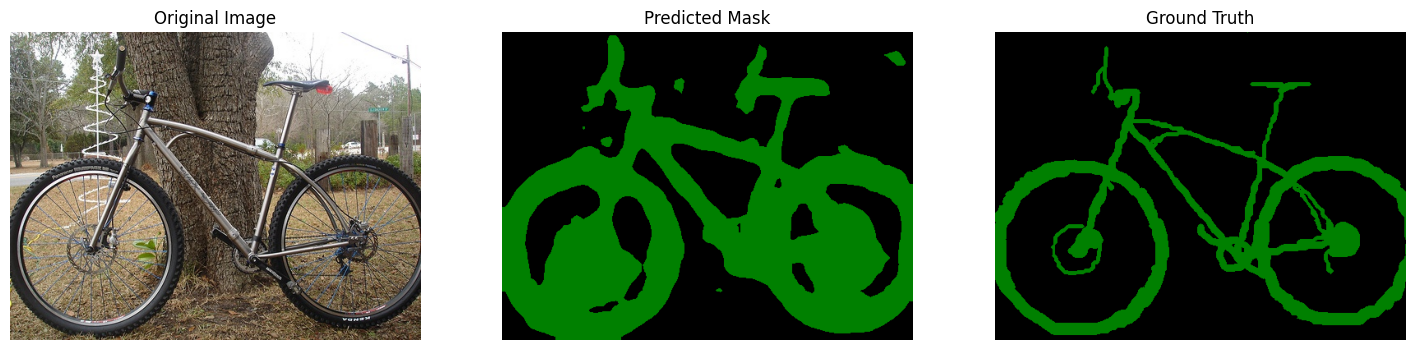


--- 正在处理图片: 2007_009221 ---


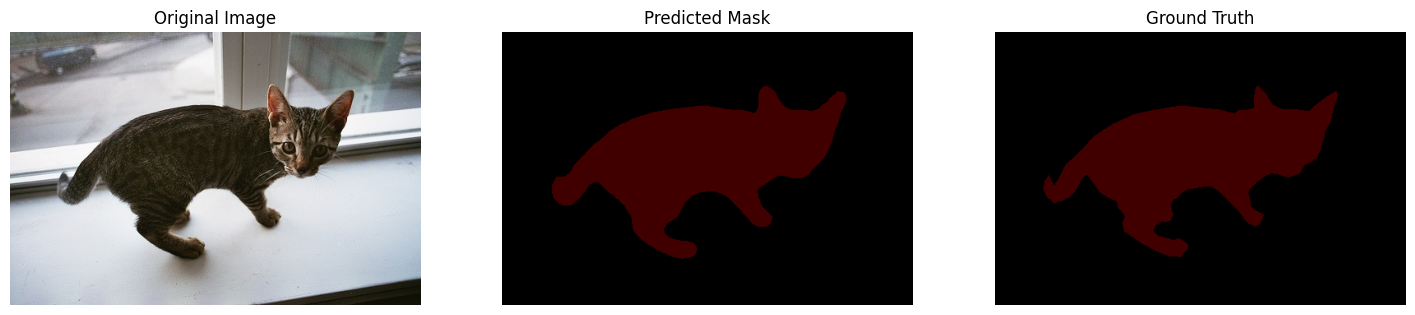


--- 正在处理图片: 2008_004562 ---


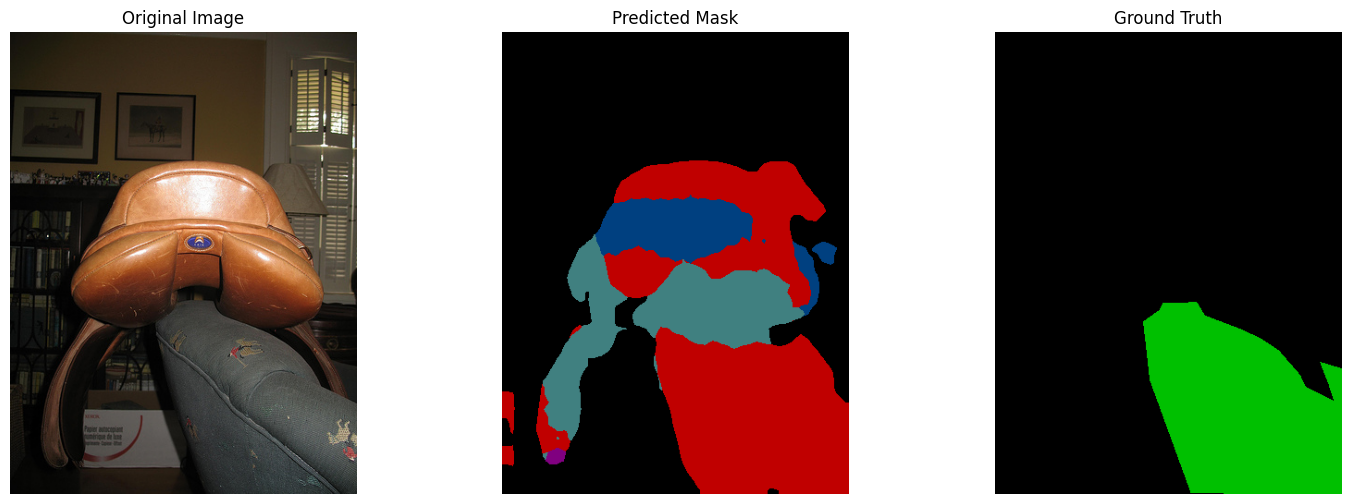


--- 正在处理图片: 2009_003810 ---


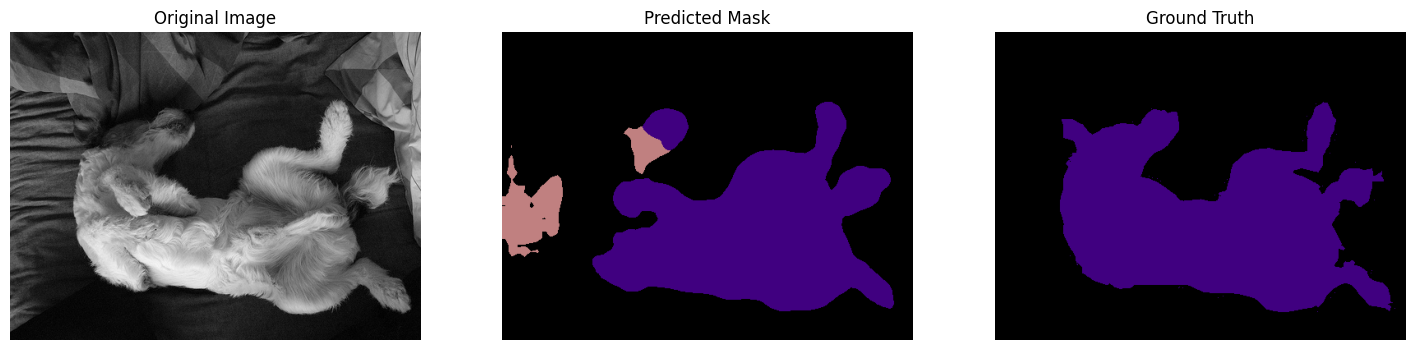


--- 正在处理图片: 2007_005547 ---


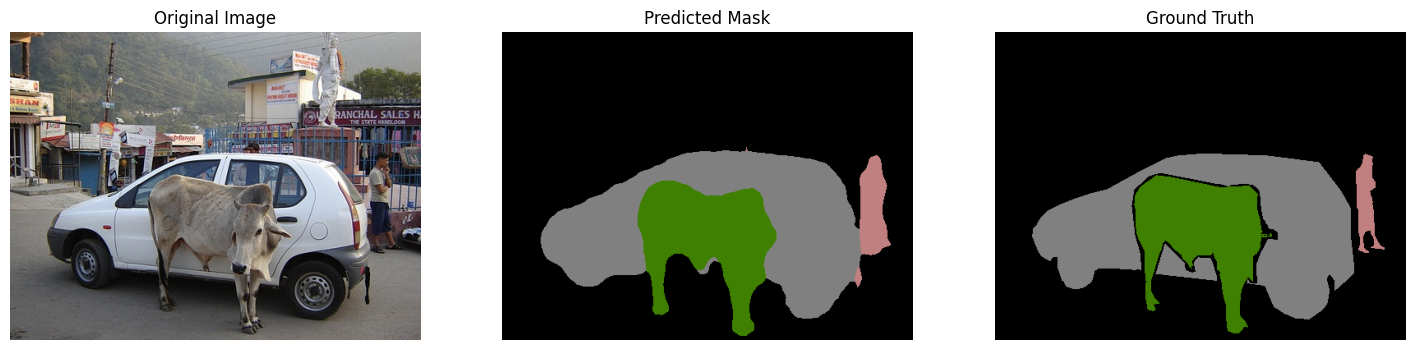


--- 正在处理图片: 2010_001951 ---


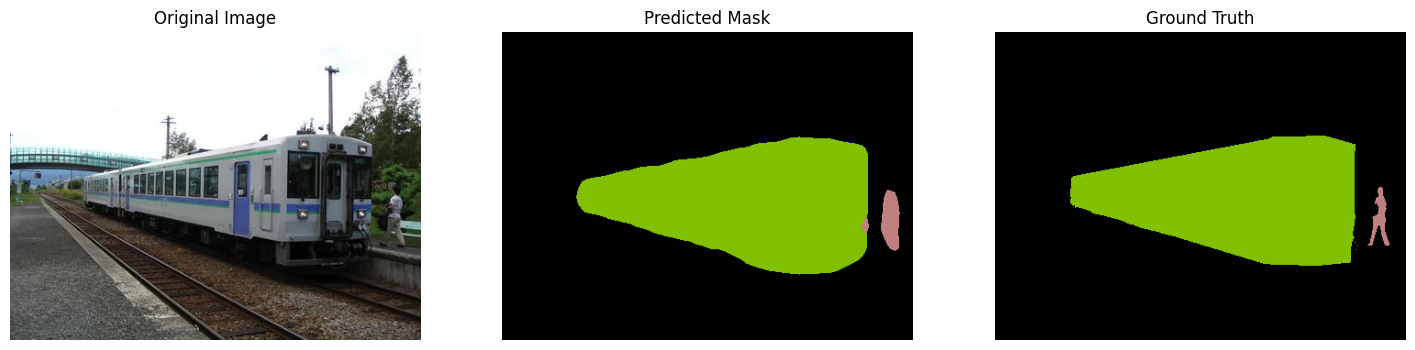

In [7]:
# ==============================================================================
# 7. 加载训练好的模型并进行可视化
# ==============================================================================
# 实例化一个新模型并加载权重
eval_model = create_model(NUM_CLASSES)
try:
    eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    eval_model.to(device)
    print("成功加载已训练的模型权重！")

    # 从验证集中随机选择3张图片进行测试
    val_list_file = os.path.join(DATA_DIR, 'ImageSets/Segmentation/val.txt')
    with open(val_list_file, 'r') as f:
        val_filenames = [line.strip() for line in f.readlines()]
    
    sample_filenames = random.sample(val_filenames, 6)

    for filename in sample_filenames:
        print(f"\n--- 正在处理图片: {filename} ---")
        img_path = os.path.join(DATA_DIR, 'JPEGImages', f'{filename}.jpg')
        mask_path = os.path.join(DATA_DIR, 'SegmentationClass', f'{filename}.png')
        visualize_prediction(eval_model, img_path, mask_path)

except FileNotFoundError:
    print(f"错误: 找不到模型文件 {MODEL_SAVE_PATH}。请先运行训练部分的Cell。")

---
# 模型改进与对比实验

在前面的单元格中，我们成功地微调了一个基础模型。现在，我们将采用更先进的策略来训练一个表现更出色的模型，并将其与原始模型进行**量化**和**可视化**的对比。

**我们的改进策略包括：**
1.  **引入标准评估指标 (mIoU)**: 使用语义分割领域最核心的指标——平均交并比 (Mean Intersection over Union) 来客观评估模型性能。
2.  **增加验证循环**: 在每个训练周期后，使用独立的验证集来评估模型的泛化能力，防止过拟合。
3.  **更优的训练策略**:
    *   使用 `AdamW` 优化器，通常比 `SGD` 收敛更快。
    *   在训练后期**解冻骨干网络**，对整个模型进行微调，以更好地适应数据集。
4.  **保存最佳模型**: 只保存在验证集上 mIoU 表现最好的模型权重。
---

In [8]:
# ==============================================================================
# 改进一：定义核心评估指标 mIoU (Mean Intersection over Union)
# ==============================================================================

def calculate_iou(pred, target, num_classes):
    """计算一个批次数据的 mIoU"""
    pred = pred.view(-1)
    target = target.view(-1)
    # 忽略值为 255 的标签
    valid_mask = (target != 255)
    pred = pred[valid_mask]
    target = target[valid_mask]
    
    iou_per_class = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            # 如果某个类别在真值和预测中都未出现，则IoU为NaN，后续计算时会忽略
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append(intersection / union)
            
    # 计算所有有效类别IoU的平均值
    return np.nanmean(iou_per_class) if iou_per_class else 0.0

print("mIoU 计算函数已定义。")

mIoU 计算函数已定义。


In [9]:
# ==============================================================================
# 改进二：使用更优的策略训练一个新模型
# ==============================================================================
print("加载预训练模型...")
# 1. 重新实例化一个新模型
improved_model = create_model(NUM_CLASSES).to(device)

# 2. 定义新的优化器和数据加载器
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, improved_model.parameters()), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

val_dataset = VOCDataset(root=DATA_DIR, split='val', crop_size=(513, 513))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# 3. 训练与验证循环
print("开始训练进阶版模型...")
best_miou = 0.0
UNFREEZE_EPOCH = 2 # 设置在第几轮后解冻骨干网络

for epoch in range(EPOCHS):
    # --- 训练阶段 ---
    improved_model.train()
    if epoch == UNFREEZE_EPOCH:
        print("\n" + "="*30 + f"\nEpoch {epoch+1}: 解冻骨干网络！\n" + "="*30 + "\n")
        for param in improved_model.backbone.parameters():
            param.requires_grad = True
        # 为所有参数创建一个新的优化器，并使用更小的学习率
        optimizer = optim.AdamW(improved_model.parameters(), lr=LEARNING_RATE / 10, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-UNFREEZE_EPOCH, eta_min=1e-6)

    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = improved_model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
    avg_train_loss = train_loss / len(train_loader)

    # --- 验证阶段 ---
    improved_model.eval()
    val_miou_list = []
    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, masks in progress_bar_val:
            images, masks = images.to(device), masks.to(device)
            outputs = improved_model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            miou = calculate_iou(preds, masks, NUM_CLASSES)
            val_miou_list.append(miou)
            progress_bar_val.set_postfix(mIoU=f"{miou:.4f}")

    avg_val_miou = np.mean(val_miou_list)
    scheduler.step()
    print(f"Epoch [{epoch+1}/{EPOCHS}] -> Train Loss: {avg_train_loss:.4f}, Val mIoU: {avg_val_miou:.4f}")

    if avg_val_miou > best_miou:
        best_miou = avg_val_miou
        torch.save(improved_model.state_dict(), IMPROVED_MODEL_SAVE_PATH)
        print(f"*** 发现更佳模型！mIoU: {best_miou:.4f}，已保存至 {IMPROVED_MODEL_SAVE_PATH} ***")

加载预训练模型...
开始训练进阶版模型...


Epoch 1/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.68it/s, mIoU=0.0406]


Epoch [1/100] -> Train Loss: 0.9768, Val mIoU: 0.3149
*** 发现更佳模型！mIoU: 0.3149，已保存至 models/deeplabv3_voc_improved.pth ***


Epoch 2/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.0871]


Epoch [2/100] -> Train Loss: 0.5714, Val mIoU: 0.3910
*** 发现更佳模型！mIoU: 0.3910，已保存至 models/deeplabv3_voc_improved.pth ***

Epoch 3: 解冻骨干网络！



Epoch 3/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.74it/s, mIoU=0.0867]


Epoch [3/100] -> Train Loss: 1.5761, Val mIoU: 0.0820


Epoch 4/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.75it/s, mIoU=0.1203]


Epoch [4/100] -> Train Loss: 1.3715, Val mIoU: 0.1176


Epoch 5/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.0649]


Epoch [5/100] -> Train Loss: 1.2948, Val mIoU: 0.1146


Epoch 6/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.78it/s, mIoU=0.0897]


Epoch [6/100] -> Train Loss: 1.2635, Val mIoU: 0.1163


Epoch 7/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.1156]


Epoch [7/100] -> Train Loss: 1.2122, Val mIoU: 0.1275


Epoch 8/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.1313]


Epoch [8/100] -> Train Loss: 1.2071, Val mIoU: 0.1320


Epoch 9/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.86it/s, mIoU=0.0049]


Epoch [9/100] -> Train Loss: 1.1678, Val mIoU: 0.1231


Epoch 10/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.87it/s, mIoU=0.0947]


Epoch [10/100] -> Train Loss: 1.1579, Val mIoU: 0.1401


Epoch 11/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.87it/s, mIoU=0.1897]


Epoch [11/100] -> Train Loss: 1.1237, Val mIoU: 0.1436


Epoch 12/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.87it/s, mIoU=0.0956]


Epoch [12/100] -> Train Loss: 1.1228, Val mIoU: 0.1302


Epoch 13/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.0806]


Epoch [13/100] -> Train Loss: 1.0985, Val mIoU: 0.1287


Epoch 14/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.0000]


Epoch [14/100] -> Train Loss: 1.0812, Val mIoU: 0.1279


Epoch 15/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.1898]


Epoch [15/100] -> Train Loss: 1.0795, Val mIoU: 0.1411


Epoch 16/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.0701]


Epoch [16/100] -> Train Loss: 1.0466, Val mIoU: 0.1484


Epoch 17/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.1193]


Epoch [17/100] -> Train Loss: 1.0404, Val mIoU: 0.1527


Epoch 18/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.89it/s, mIoU=0.0586]


Epoch [18/100] -> Train Loss: 1.0272, Val mIoU: 0.1385


Epoch 19/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.89it/s, mIoU=0.1070]


Epoch [19/100] -> Train Loss: 0.9901, Val mIoU: 0.1576


Epoch 20/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.89it/s, mIoU=0.0634]


Epoch [20/100] -> Train Loss: 0.9882, Val mIoU: 0.1418


Epoch 21/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.89it/s, mIoU=0.1769]


Epoch [21/100] -> Train Loss: 0.9803, Val mIoU: 0.1399


Epoch 22/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.91it/s, mIoU=0.0626]


Epoch [22/100] -> Train Loss: 0.9576, Val mIoU: 0.1340


Epoch 23/100 [Val]: 100%|██████████| 363/363 [00:40<00:00,  8.88it/s, mIoU=0.1898]


Epoch [23/100] -> Train Loss: 0.9068, Val mIoU: 0.1437


Epoch 24/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.78it/s, mIoU=0.0666]


Epoch [24/100] -> Train Loss: 0.9302, Val mIoU: 0.1781


Epoch 25/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.76it/s, mIoU=0.0566]


Epoch [25/100] -> Train Loss: 0.8974, Val mIoU: 0.1699


Epoch 26/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1898]


Epoch [26/100] -> Train Loss: 0.8924, Val mIoU: 0.1742


Epoch 27/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.0380]


Epoch [27/100] -> Train Loss: 0.8450, Val mIoU: 0.1800


Epoch 28/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.1271]


Epoch [28/100] -> Train Loss: 0.8818, Val mIoU: 0.1713


Epoch 29/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.1898]


Epoch [29/100] -> Train Loss: 0.8313, Val mIoU: 0.1736


Epoch 30/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.0356]


Epoch [30/100] -> Train Loss: 0.8278, Val mIoU: 0.1822


Epoch 31/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1264]


Epoch [31/100] -> Train Loss: 0.8169, Val mIoU: 0.1672


Epoch 32/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1358]


Epoch [32/100] -> Train Loss: 0.7960, Val mIoU: 0.1712


Epoch 33/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1898]


Epoch [33/100] -> Train Loss: 0.7672, Val mIoU: 0.1583


Epoch 34/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0901]


Epoch [34/100] -> Train Loss: 0.7854, Val mIoU: 0.1628


Epoch 35/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0010]


Epoch [35/100] -> Train Loss: 0.7727, Val mIoU: 0.1544


Epoch 36/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0950]


Epoch [36/100] -> Train Loss: 0.7904, Val mIoU: 0.1874


Epoch 37/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0860]


Epoch [37/100] -> Train Loss: 0.7437, Val mIoU: 0.1937


Epoch 38/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0749]


Epoch [38/100] -> Train Loss: 0.7414, Val mIoU: 0.1940


Epoch 39/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0643]


Epoch [39/100] -> Train Loss: 0.7372, Val mIoU: 0.1921


Epoch 40/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0268]


Epoch [40/100] -> Train Loss: 0.7005, Val mIoU: 0.1974


Epoch 41/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0657]


Epoch [41/100] -> Train Loss: 0.7156, Val mIoU: 0.2010


Epoch 42/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.74it/s, mIoU=0.0207]


Epoch [42/100] -> Train Loss: 0.6896, Val mIoU: 0.1911


Epoch 43/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.74it/s, mIoU=0.0759]


Epoch [43/100] -> Train Loss: 0.7113, Val mIoU: 0.2033


Epoch 44/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.1146]


Epoch [44/100] -> Train Loss: 0.6498, Val mIoU: 0.2109


Epoch 45/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.75it/s, mIoU=0.1898]


Epoch [45/100] -> Train Loss: 0.6612, Val mIoU: 0.2150


Epoch 46/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.75it/s, mIoU=0.0000]


Epoch [46/100] -> Train Loss: 0.6623, Val mIoU: 0.2044


Epoch 47/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0450]


Epoch [47/100] -> Train Loss: 0.6564, Val mIoU: 0.2152


Epoch 48/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1412]


Epoch [48/100] -> Train Loss: 0.6454, Val mIoU: 0.2057


Epoch 49/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.74it/s, mIoU=0.0859]


Epoch [49/100] -> Train Loss: 0.6126, Val mIoU: 0.2167


Epoch 50/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.1266]


Epoch [50/100] -> Train Loss: 0.5963, Val mIoU: 0.2018


Epoch 51/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.76it/s, mIoU=0.0945]


Epoch [51/100] -> Train Loss: 0.6160, Val mIoU: 0.2132


Epoch 52/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.75it/s, mIoU=0.0678]


Epoch [52/100] -> Train Loss: 0.5940, Val mIoU: 0.2124


Epoch 53/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.76it/s, mIoU=0.1389]


Epoch [53/100] -> Train Loss: 0.5999, Val mIoU: 0.2032


Epoch 54/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.76it/s, mIoU=0.0005]


Epoch [54/100] -> Train Loss: 0.5658, Val mIoU: 0.1951


Epoch 55/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.75it/s, mIoU=0.0588]


Epoch [55/100] -> Train Loss: 0.5916, Val mIoU: 0.1870


Epoch 56/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.74it/s, mIoU=0.0436]


Epoch [56/100] -> Train Loss: 0.5530, Val mIoU: 0.2105


Epoch 57/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.75it/s, mIoU=0.0957]


Epoch [57/100] -> Train Loss: 0.5453, Val mIoU: 0.2254


Epoch 58/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.75it/s, mIoU=0.0293]


Epoch [58/100] -> Train Loss: 0.5536, Val mIoU: 0.2151


Epoch 59/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.74it/s, mIoU=0.0384]


Epoch [59/100] -> Train Loss: 0.5331, Val mIoU: 0.2222


Epoch 60/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.0000]


Epoch [60/100] -> Train Loss: 0.5156, Val mIoU: 0.1970


Epoch 61/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0000]


Epoch [61/100] -> Train Loss: 0.5080, Val mIoU: 0.2087


Epoch 62/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0960]


Epoch [62/100] -> Train Loss: 0.5162, Val mIoU: 0.2132


Epoch 63/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.1096]


Epoch [63/100] -> Train Loss: 0.5245, Val mIoU: 0.2188


Epoch 64/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0883]


Epoch [64/100] -> Train Loss: 0.4980, Val mIoU: 0.2209


Epoch 65/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0872]


Epoch [65/100] -> Train Loss: 0.4793, Val mIoU: 0.2295


Epoch 66/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0259]


Epoch [66/100] -> Train Loss: 0.4617, Val mIoU: 0.2250


Epoch 67/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.1537]


Epoch [67/100] -> Train Loss: 0.4756, Val mIoU: 0.2347


Epoch 68/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1549]


Epoch [68/100] -> Train Loss: 0.4589, Val mIoU: 0.2279


Epoch 69/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.1300]


Epoch [69/100] -> Train Loss: 0.4592, Val mIoU: 0.2398


Epoch 70/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.2245]


Epoch [70/100] -> Train Loss: 0.4504, Val mIoU: 0.2354


Epoch 71/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0505]


Epoch [71/100] -> Train Loss: 0.4437, Val mIoU: 0.2419


Epoch 72/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.1616]


Epoch [72/100] -> Train Loss: 0.4275, Val mIoU: 0.2258


Epoch 73/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.1424]


Epoch [73/100] -> Train Loss: 0.4219, Val mIoU: 0.2442


Epoch 74/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.0602]


Epoch [74/100] -> Train Loss: 0.4236, Val mIoU: 0.2320


Epoch 75/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1037]


Epoch [75/100] -> Train Loss: 0.4083, Val mIoU: 0.2470


Epoch 76/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0467]


Epoch [76/100] -> Train Loss: 0.4016, Val mIoU: 0.2376


Epoch 77/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.73it/s, mIoU=0.1743]


Epoch [77/100] -> Train Loss: 0.4078, Val mIoU: 0.2372


Epoch 78/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.0743]


Epoch [78/100] -> Train Loss: 0.3832, Val mIoU: 0.2333


Epoch 79/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1464]


Epoch [79/100] -> Train Loss: 0.3795, Val mIoU: 0.2383


Epoch 80/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0587]


Epoch [80/100] -> Train Loss: 0.3842, Val mIoU: 0.2344


Epoch 81/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1882]


Epoch [81/100] -> Train Loss: 0.3783, Val mIoU: 0.2390


Epoch 82/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0627]


Epoch [82/100] -> Train Loss: 0.3793, Val mIoU: 0.2325


Epoch 83/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0613]


Epoch [83/100] -> Train Loss: 0.3765, Val mIoU: 0.2334


Epoch 84/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.1020]


Epoch [84/100] -> Train Loss: 0.3791, Val mIoU: 0.2402


Epoch 85/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.1078]


Epoch [85/100] -> Train Loss: 0.3583, Val mIoU: 0.2353


Epoch 86/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.0767]


Epoch [86/100] -> Train Loss: 0.3575, Val mIoU: 0.2432


Epoch 87/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.2479]


Epoch [87/100] -> Train Loss: 0.3496, Val mIoU: 0.2343


Epoch 88/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0859]


Epoch [88/100] -> Train Loss: 0.3579, Val mIoU: 0.2300


Epoch 89/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.0757]


Epoch [89/100] -> Train Loss: 0.3512, Val mIoU: 0.2282


Epoch 90/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.2815]


Epoch [90/100] -> Train Loss: 0.3496, Val mIoU: 0.2372


Epoch 91/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.69it/s, mIoU=0.0027]


Epoch [91/100] -> Train Loss: 0.3410, Val mIoU: 0.2458


Epoch 92/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.0947]


Epoch [92/100] -> Train Loss: 0.3572, Val mIoU: 0.2338


Epoch 93/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.0392]


Epoch [93/100] -> Train Loss: 0.3555, Val mIoU: 0.2329


Epoch 94/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.69it/s, mIoU=0.1995]


Epoch [94/100] -> Train Loss: 0.3574, Val mIoU: 0.2336


Epoch 95/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.1188]


Epoch [95/100] -> Train Loss: 0.3347, Val mIoU: 0.2223


Epoch 96/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.1450]


Epoch [96/100] -> Train Loss: 0.3421, Val mIoU: 0.2338


Epoch 97/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.1039]


Epoch [97/100] -> Train Loss: 0.3406, Val mIoU: 0.2295


Epoch 98/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s, mIoU=0.0010]


Epoch [98/100] -> Train Loss: 0.3398, Val mIoU: 0.2364


Epoch 99/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.70it/s, mIoU=0.0101]


Epoch [99/100] -> Train Loss: 0.3366, Val mIoU: 0.2456


Epoch 100/100 [Val]: 100%|██████████| 363/363 [00:41<00:00,  8.72it/s, mIoU=0.1473]

Epoch [100/100] -> Train Loss: 0.3409, Val mIoU: 0.2278


In [10]:
# ==============================================================================
# 对比一：mIoU 分数比较
# ==============================================================================

def evaluate_model_miou(model, data_loader, device):
    """在给定的数据集上评估模型的 mIoU"""
    model.eval()
    all_miou = []
    with torch.no_grad():
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            miou = calculate_iou(preds, masks, NUM_CLASSES)
            all_miou.append(miou)
    return np.mean(all_miou)

# 加载原始模型
original_model = create_model(NUM_CLASSES).to(device)
original_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# 加载改进后的模型
improved_model_eval = create_model(NUM_CLASSES).to(device)
improved_model_eval.load_state_dict(torch.load(IMPROVED_MODEL_SAVE_PATH))

print("正在验证集上评估两个模型...")
original_miou = evaluate_model_miou(original_model, val_loader, device)
improved_miou = evaluate_model_miou(improved_model_eval, val_loader, device)

print("\n" + "="*40)
print("       模型性能量化对比 (mIoU)")
print("="*40)
print(f"原始模型 mIoU: {original_miou:.4f}")
print(f"改进模型 mIoU: {improved_miou:.4f}")
print("="*40)

if improved_miou > original_miou:
    print("\n结论：改进后的模型在 mIoU 指标上表现更出色！")
else:
    print("\n结论：改进策略未带来明显提升，可以尝试调整超参数或增加训练轮次。")

正在验证集上评估两个模型...


Evaluating: 100%|██████████| 363/363 [00:41<00:00,  8.71it/s]


       模型性能量化对比 (mIoU)
原始模型 mIoU: 0.6448
改进模型 mIoU: 0.3951

结论：改进策略未带来明显提升，可以尝试调整超参数或增加训练轮次。


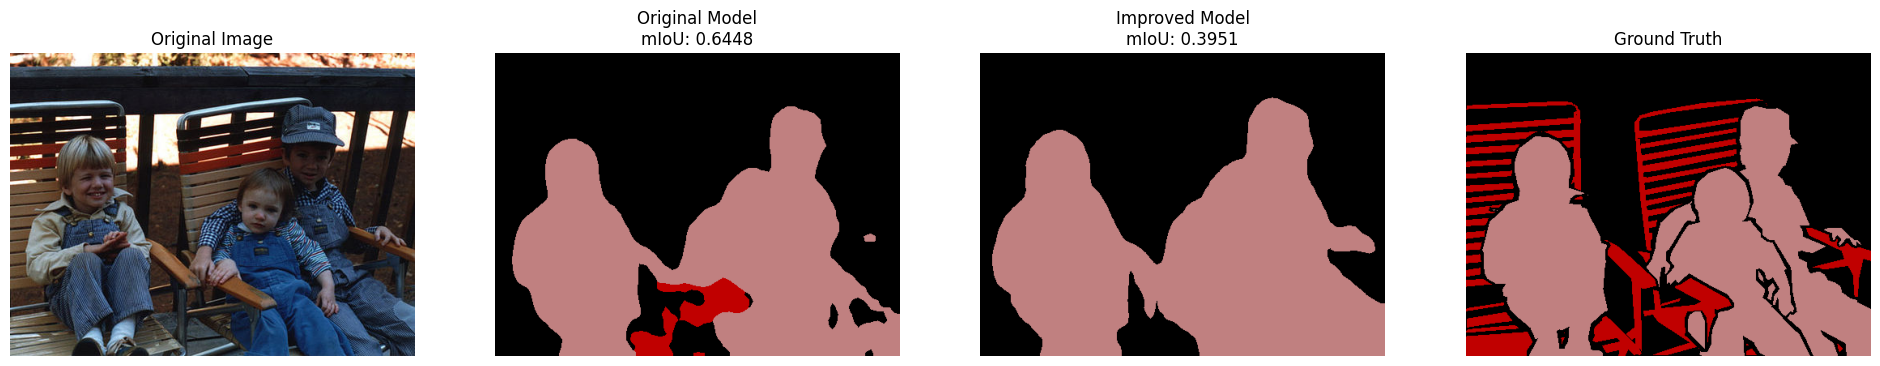

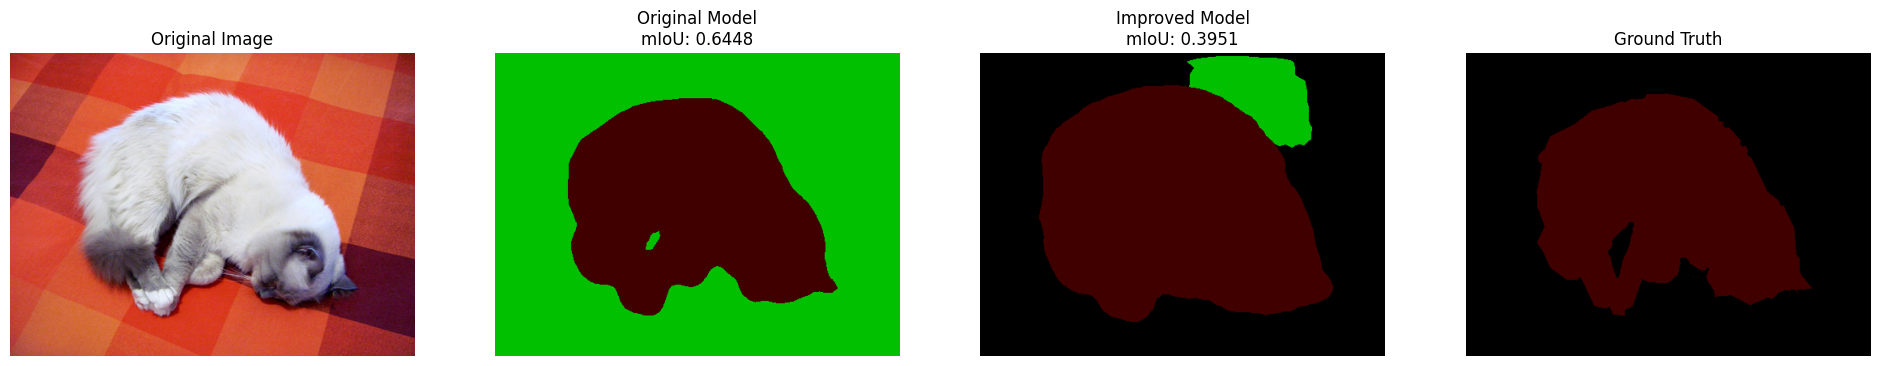

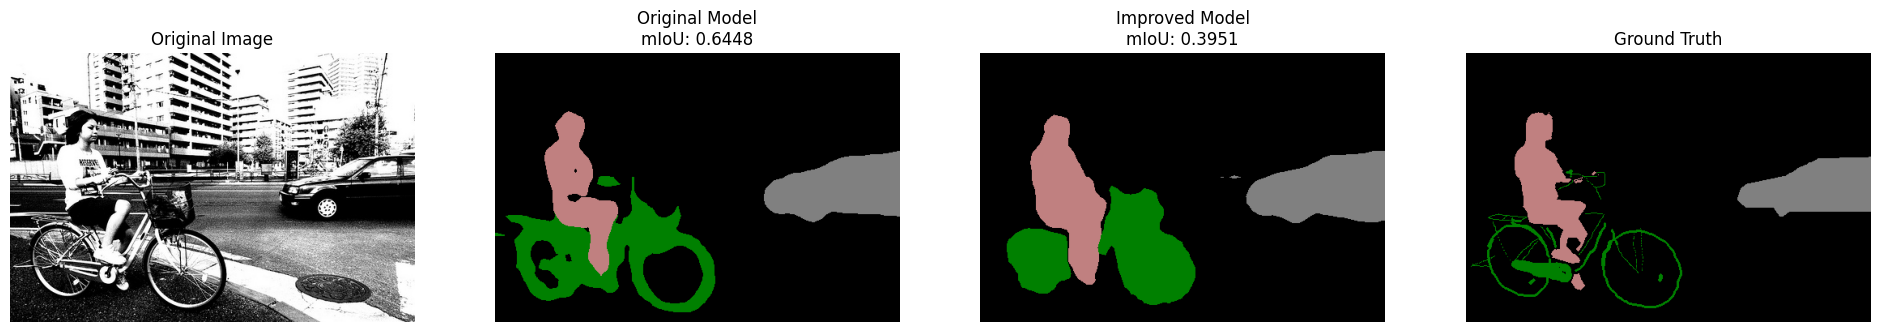

In [11]:
# ==============================================================================
# 对比二：分割效果可视化比较
# ==============================================================================

def visualize_comparison(model1, model2, image_path, mask_path):
    """并排显示原图、两个模型的预测以及真实标签"""
    image = Image.open(image_path).convert('RGB')
    
    # --- 预处理 ---
    input_image = F.to_tensor(image) * 255.0
    input_image = F.normalize(input_image, mean=[123.675, 116.28, 103.53], std=[58.395, 57.120, 57.375])
    input_image = input_image.unsqueeze(0).to(device)

    # --- 模型预测 ---
    model1.eval()
    model2.eval()
    with torch.no_grad():
        pred1 = torch.argmax(model1(input_image)['out'][0], dim=0).cpu().numpy()
        pred2 = torch.argmax(model2(input_image)['out'][0], dim=0).cpu().numpy()
        
    mask1_colored = VOC_COLORMAP[pred1]
    mask2_colored = VOC_COLORMAP[pred2]

    # --- 加载真实标签 ---
    true_mask_pil = Image.open(mask_path)
    true_mask_np = np.array(true_mask_pil)
    true_mask_np[true_mask_np == 255] = 0
    true_mask_colored = VOC_COLORMAP[true_mask_np]

    # --- 可视化 ---
    plt.figure(figsize=(24, 6))
    plt.subplot(1, 4, 1); plt.title("Original Image"); plt.imshow(image); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title(f"Original Model\nmIoU: {original_miou:.4f}"); plt.imshow(mask1_colored); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title(f"Improved Model\nmIoU: {improved_miou:.4f}"); plt.imshow(mask2_colored); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title("Ground Truth"); plt.imshow(true_mask_colored); plt.axis('off')
    plt.show()

# 从验证集中随机选择3张图片进行对比
val_list_file = os.path.join(DATA_DIR, 'ImageSets/Segmentation/val.txt')
with open(val_list_file, 'r') as f:
    val_filenames = [line.strip() for line in f.readlines()]
sample_filenames = random.sample(val_filenames, 3)

for filename in sample_filenames:
    img_path = os.path.join(DATA_DIR, 'JPEGImages', f'{filename}.jpg')
    mask_path = os.path.join(DATA_DIR, 'SegmentationClass', f'{filename}.png')
    visualize_comparison(original_model, improved_model_eval, img_path, mask_path)